In [1]:
# Import necessary libraries
import yt
import numpy as np
import matplotlib.pyplot as plt
import os
from matplotlib.colors import LogNorm
import logging
yt_logger = logging.getLogger('yt')
original_level = yt_logger.level
yt_logger.setLevel(logging.WARNING) 

# Directory paths
basedir = "/pscratch/sd/x/xinshuo/runGReX/"
plotdir = "/pscratch/sd/x/xinshuo/plotGReX/"

# Configure matplotlib for better plots
plt.rcParams['figure.figsize'] = [10, 8]
plt.rcParams['font.size'] = 14


In [44]:
# Define the sets of simulations
velocity_simnames = [
    (0.7, '20250622_tune_damping_n256_v07'),
    (0.6, '20250621_tune_damping_n256_v06'),
    (0.55, '20250623_tune_damping_n256_v055'),
    (0.5, '20250620_tune_damping_n256_1'),
    (0.45, '20250623_tune_damping_n256_v045'),
    (0.4, '20250622_tune_damping_n256_v04'),
    (0.3, '20250622_tune_damping_n256_v03')
]

ncell_simnames = [
    (256, '20250620_tune_damping_n256_1'),
    (192, '20250621_tune_damping_n192'),
    (128, '20250621_tune_damping_n128')
]

# Set up parameters
time_snapshot = 8000  # Time to compare (in M)
extent_x = 100        # Extent in x direction
extent_y = 100        # Extent in y direction
plot_cmap_max = 0.01  # Maximum value for colormap
plot_cmap_min = 0.00001  # Minimum value for colormap

# Let's start with just one simulation to test
test_simname = velocity_simnames[3][1]  # Use v=0.5 as test
print(f"Test simulation: {test_simname}")


Test simulation: 20250620_tune_damping_n256_1


In [45]:
# Step 1: Find all datasets in the simulation directory
def list_datasets(simname):
    rundir = os.path.join(basedir, simname)
    plt_dirs = sorted([d for d in os.listdir(rundir) if d.startswith('plt') and d[3:].isdigit()], 
                     key=lambda x: int(x[3:]))
    return plt_dirs

# List the first few datasets
plt_dirs = list_datasets(test_simname)
print(f"Found {len(plt_dirs)} datasets")
print(f"First few datasets: {plt_dirs[:5]}")
print(f"Last few datasets: {plt_dirs[-5:]}")


Found 436 datasets
First few datasets: ['plt02036', 'plt04071', 'plt06106', 'plt08142', 'plt10177']
Last few datasets: ['plt879241', 'plt881277', 'plt883312', 'plt885347', 'plt887382']


In [46]:
# Step 2: Check dataset times to find the one closest to our target time
def find_closest_dataset_time(simname, target_time):
    rundir = os.path.join(basedir, simname)
    plt_dirs = list_datasets(simname)
    
    closest_path = None
    closest_time = None
    min_time_diff = float('inf')  # Initialize min_time_diff variable
    times = []
    
    print(f"Found {len(plt_dirs)} datasets, using first 2 to determine time step...")
    
    # Load only the first 2 datasets to determine the time step
    if len(plt_dirs) >= 2:
        # Get times from first two datasets
        ds1 = yt.load(os.path.join(rundir, plt_dirs[0]))
        ds2 = yt.load(os.path.join(rundir, plt_dirs[1]))
        
        time1 = float(ds1.current_time)
        time2 = float(ds2.current_time)
        
        # Calculate time step
        dt = time2 - time1
        
        # Calculate the expected index for target time
        target_idx = round((target_time - time1) / dt)
        target_idx = max(0, min(target_idx, len(plt_dirs) - 1))  # Ensure within bounds
        
        # Get the closest dataset
        plt_dir = plt_dirs[target_idx]
        ds_path = os.path.join(rundir, plt_dir)
        ds = yt.load(ds_path)
        
        closest_time = float(ds.current_time)
        closest_path = ds_path
        min_time_diff = abs(closest_time - target_time)  # Calculate the time difference
        times.append((plt_dir, closest_time))
        
        print(f"Using time step dt = {dt:.2f}M, estimated index: {target_idx}")
    else:
        print("Not enough datasets to determine time step")
    if closest_path:
        print(f"Found dataset at time {closest_time:.2f}M (diff: {min_time_diff:.2f}M)")
    
    return closest_path, closest_time, times

# Find dataset closest to our target time
closest_path, closest_time, times = find_closest_dataset_time(test_simname, time_snapshot)
print(f"Closest dataset to time {time_snapshot}M: {closest_path} (time: {closest_time}M)")


Found 436 datasets, using first 2 to determine time step...
Using time step dt = 49.99M, estimated index: 159
Found dataset at time 8000.01M (diff: 0.01M)
Closest dataset to time 8000M: /pscratch/sd/x/xinshuo/runGReX/20250620_tune_damping_n256_1/plt325645 (time: 8000.00686645508M)


In [47]:
# Step 3: Load the dataset and check available fields
if closest_path:
    # Load the dataset explicitly
    ds = yt.load(closest_path)
    print(f"Loaded dataset from {closest_path}")
    print(f"Time: {ds.current_time}M")
    print(f"Available fields: {ds.field_list}")
    
    # Check if RHO_ENERGY is available
    if ('boxlib', 'RHO_ENERGY') in ds.field_list:
        print("RHO_ENERGY field is available")
    else:
        print("WARNING: RHO_ENERGY field not found!")
        available_fields = [f[1] for f in ds.field_list if f[0] == 'boxlib']
        print(f"Available boxlib fields: {available_fields}")
        # If RHO_ENERGY not found, check for similar fields
        possible_energy_fields = [f for f in available_fields if 'energy' in f.lower() or 'rho' in f.lower()]
        if possible_energy_fields:
            print(f"Possible energy-related fields: {possible_energy_fields}")
else:
    print("No dataset loaded to check fields")


Loaded dataset from /pscratch/sd/x/xinshuo/runGReX/20250620_tune_damping_n256_1/plt325645
Time: 8000.00686645508 code_timeM
Available fields: [('boxlib', 'ALPHA'), ('boxlib', 'ATXX'), ('boxlib', 'ATXY'), ('boxlib', 'ATXZ'), ('boxlib', 'ATYY'), ('boxlib', 'ATYZ'), ('boxlib', 'ATZZ'), ('boxlib', 'BETAX'), ('boxlib', 'BETAY'), ('boxlib', 'BETAZ'), ('boxlib', 'ENERGY_DISSIPATION'), ('boxlib', 'ENERGY_FLUX'), ('boxlib', 'GTXX'), ('boxlib', 'GTXY'), ('boxlib', 'GTXZ'), ('boxlib', 'GTYY'), ('boxlib', 'GTYZ'), ('boxlib', 'GTZZ'), ('boxlib', 'QCHARGE'), ('boxlib', 'QCHARGE_FLUX'), ('boxlib', 'RHO_ENERGY'), ('boxlib', 'SMOMENTUM_X'), ('boxlib', 'SMOMENTUM_Y'), ('boxlib', 'SMOMENTUM_Z'), ('boxlib', 'SPHI'), ('boxlib', 'SPHI2'), ('boxlib', 'SPI'), ('boxlib', 'SPI2'), ('boxlib', 'STRK'), ('boxlib', 'SURFACE_X'), ('boxlib', 'SURFACE_Y'), ('boxlib', 'SURFACE_Z'), ('boxlib', 'TRK'), ('boxlib', 'VOLUME_X'), ('boxlib', 'VOLUME_Y'), ('boxlib', 'VOLUME_Z'), ('boxlib', 'W')]
RHO_ENERGY field is available



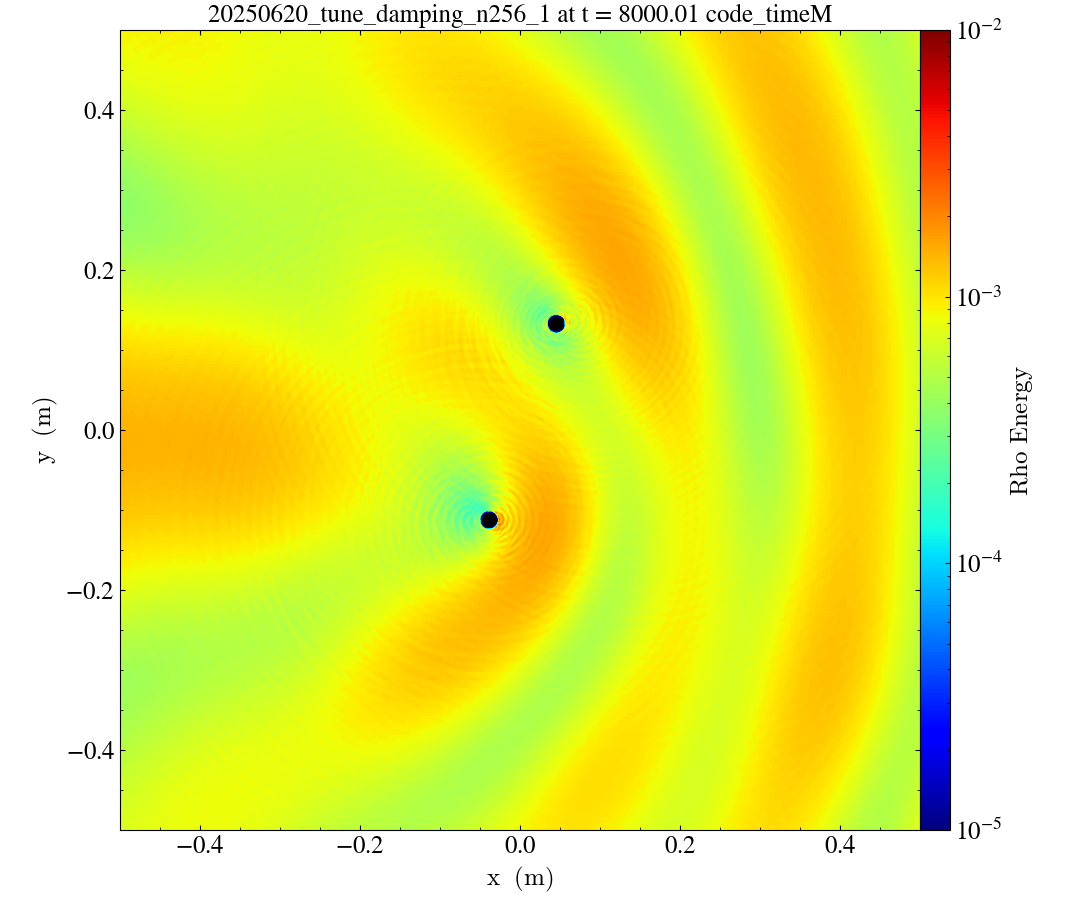

Data shape: (800, 800)
Data range: 0.0 to 0.0028553894299829462
Saved plot to /pscratch/sd/x/xinshuo/plotGReX/test_rho_energy_t8000 code_time.png


In [48]:
# Step 4: Create a slice and visualize it for a single dataset
if closest_path and ('boxlib', 'RHO_ENERGY') in ds.field_list:
    # Create a slice plot
    slc = yt.SlicePlot(ds, 'z', 'RHO_ENERGY')
    
    # Set width to our desired extent
    slc.set_width((extent_x, extent_y))
    
    # Set log scale
    slc.set_log('RHO_ENERGY', True)
    
    # Set colormap
    slc.set_cmap('RHO_ENERGY', 'jet')
    slc.set_zlim('RHO_ENERGY', plot_cmap_min, plot_cmap_max)
    
    # Add title
    slc.annotate_title(f"{test_simname} at t = {ds.current_time:.2f}M")
    
    # Display the plot
    slc.show()
    
    # Get the raw data for debugging
    frb = slc.frb
    data = frb['RHO_ENERGY'].d
    print(f"Data shape: {data.shape}")
    print(f"Data range: {data.min()} to {data.max()}")
    
    # Save to disk
    output_path = os.path.join(plotdir, f"test_rho_energy_t{ds.current_time:.0f}.png")
    slc.save(output_path)
    print(f"Saved plot to {output_path}")
else:
    print("Cannot create plot - dataset not loaded or RHO_ENERGY field not available")


In [35]:
# Step 5: Function to load data for multiple simulations
def load_datasets_by_time(simnames, target_time):
    datasets = {}
    
    for param_value, simname in simnames:
        print(f"\nProcessing simulation: {simname} ({param_value})")
        # Find the closest dataset
        closest_path, closest_time, _ = find_closest_dataset_time(simname, target_time)
        
        if closest_path and closest_time:
            # Load the dataset
            ds = yt.load(closest_path)
            
            # Check if RHO_ENERGY is available
            if ('boxlib', 'RHO_ENERGY') in ds.field_list:
                # Create a slice plot to get the data
                slc = yt.SlicePlot(ds, 'z', 'RHO_ENERGY')
                slc.set_width((extent_x, extent_y))
                
                # Get the raw data
                frb = slc.frb
                data = frb['RHO_ENERGY'].d
                
                # Get spatial coordinates
                x_left = -extent_x/2
                x_right = extent_x/2
                y_bottom = -extent_y/2
                y_top = extent_y/2
                
                x = np.linspace(x_left, x_right, data.shape[0])
                y = np.linspace(y_bottom, y_top, data.shape[1])
                
                # Store the data
                datasets[param_value] = {
                    'data': data,
                    'x': x,
                    'y': y,
                    'time': closest_time,
                    'path': closest_path
                }
                
                print(f"  ✓ Loaded dataset with time {closest_time:.2f}M")
                print(f"  ✓ Data shape: {data.shape}, range: {data.min():.8f} to {data.max():.8f}")
            else:
                print(f"  ✗ RHO_ENERGY field not available in {closest_path}")
        else:
            print(f"  ✗ No suitable dataset found for {simname}")
    
    return datasets

# Test with a small subset (first 3 velocity simulations)
test_velocity_simnames = velocity_simnames[:3]
velocity_datasets = load_datasets_by_time(test_velocity_simnames, time_snapshot)
print(f"\nLoaded {len(velocity_datasets)} datasets for velocity comparison")



Processing simulation: 20250622_tune_damping_n256_v07 (0.7)
Found 292 datasets, using first 2 to determine time step...
Using time step dt = 49.99M, estimated index: 159
Found dataset at time 8000.01M (diff: 0.01M)
  ✓ Loaded dataset with time 8000.01M
  ✓ Data shape: (800, 800), range: 0.00000000 to 0.00167780

Processing simulation: 20250621_tune_damping_n256_v06 (0.6)
Found 252 datasets, using first 2 to determine time step...
Using time step dt = 49.99M, estimated index: 159
Found dataset at time 8000.01M (diff: 0.01M)
  ✓ Loaded dataset with time 8000.01M
  ✓ Data shape: (800, 800), range: 0.00000000 to 0.00204978

Processing simulation: 20250623_tune_damping_n256_v055 (0.55)
Found 275 datasets, using first 2 to determine time step...
Using time step dt = 50.02M, estimated index: 160
Found dataset at time 8000.01M (diff: 0.01M)
  ✓ Loaded dataset with time 8000.01M
  ✓ Data shape: (800, 800), range: 0.00000000 to 0.00211632

Loaded 3 datasets for velocity comparison


Creating 3-panel plot: Comparison of $\rho$ across different velocities at t ≈ 8000M
  Plotting panel 1/3: v = 0.55
  Plotting panel 2/3: v = 0.6
  Plotting panel 3/3: v = 0.7
  Adding colorbar...
  Adjusting layout...


/tmp/ipykernel_82271/1169290567.py:100: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.9, 0.96])  # Left, bottom, right, top


  Saving figure...
  ✓ Saved multi-panel plot to /pscratch/sd/x/xinshuo/plotGReX/rho_energy_velocity_comparison_t8000_test.pdf


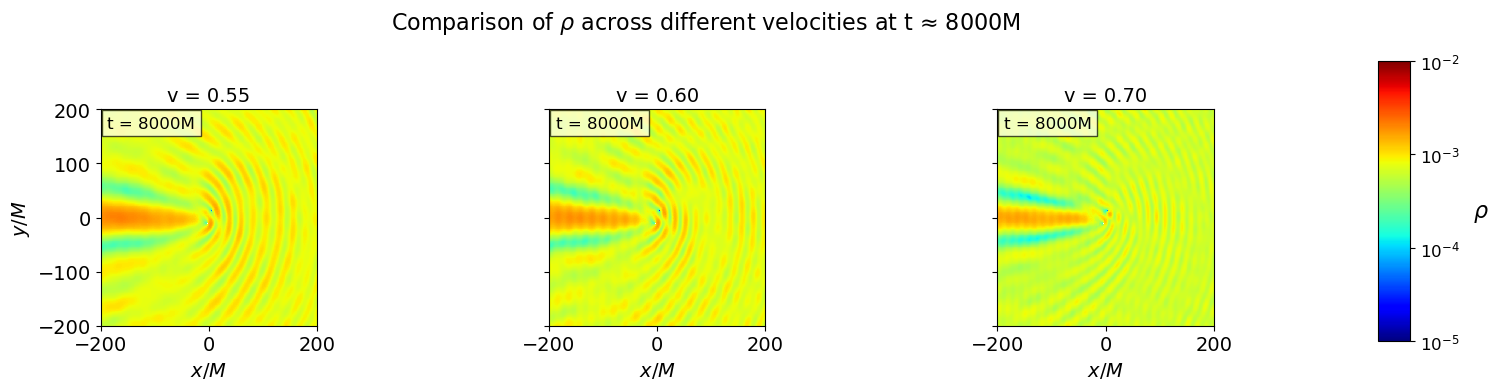

In [36]:
# Step 6: Create a function for multi-panel plots
def create_multipanel_plot(datasets, title, filename, vmin, vmax):
    if not datasets:
        print("No datasets to plot!")
        return
        
    # Sort by parameter values (velocity or resolution)
    sorted_params = sorted(datasets.keys())
    n_plots = len(sorted_params)
    
    print(f"Creating {n_plots}-panel plot: {title}")
    
    # Determine grid layout
    cols = min(3, n_plots)
    rows = (n_plots + cols - 1) // cols
    
    # Create figure and axes with extra space for colorbar
    fig, axes = plt.subplots(rows, cols, figsize=(5*cols+1, 4*rows), 
                           sharex=True, sharey=True, constrained_layout=False)
    
    # Convert axes to array for consistent indexing
    if rows == 1 and cols == 1:
        axes = np.array([axes])
    elif rows == 1 or cols == 1:
        axes = axes.reshape(-1)
        
    # Create the plots
    for i, param in enumerate(sorted_params):
        print(f"  Plotting panel {i+1}/{n_plots}: {'N = '+str(param) if isinstance(param, int) else 'v = '+str(param)}")
        data_dict = datasets[param]
        data = data_dict['data']
        x = data_dict['x']
        y = data_dict['y']
        time = data_dict['time']
        
        # Calculate extent for imshow
        extent = [min(x), max(x), min(y), max(y)]
        
        # Get subplot
        ax = axes.flat[i] if len(axes.flat) > 1 else axes
        
        # Create plot with imshow instead of pcolormesh for better performance
        # Remove the .T transpose since the data is already in the right orientation
        im = ax.imshow(data, norm=LogNorm(vmin=vmin, vmax=vmax),
                      cmap='jet', origin='lower', extent=extent, 
                      interpolation='nearest', aspect='auto')
        
        # Add title for this panel
        if isinstance(param, int):
            ax.set_title(f'N = {param}', fontsize=14)
        else:
            ax.set_title(f'v = {param:.2f}', fontsize=14)
            
        # Add time stamp
        ax.text(0.03, 0.97, f't = {time:.0f}M', transform=ax.transAxes,
              fontsize=12, va='top', ha='left', 
              bbox=dict(facecolor='white', alpha=0.7))
        
        # Set labels on outer plots
        if i >= n_plots - cols:  # Bottom row
            ax.set_xlabel('$x/M$', fontsize=14)
        if i % cols == 0:  # First column
            ax.set_ylabel('$y/M$', fontsize=14)
            
        # Set equal aspect ratio
        ax.set_aspect('equal')
    
    # Hide any unused subplots
    for j in range(n_plots, rows*cols):
        if j < len(axes.flat):
            print(f"  Hiding unused panel {j+1}")
            axes.flat[j].axis('off')
    
    print("  Adding colorbar...")
    # Add colorbar with improved styling and positioning
    from mpl_toolkits.axes_grid1 import make_axes_locatable
    
    # Create a single colorbar for the entire figure
    cax = fig.add_axes([0.92, 0.15, 0.02, 0.7])  # [x, y, width, height]
    cbar = fig.colorbar(im, cax=cax)
    cbar.set_label('$\\rho$', fontsize=16, rotation=0, labelpad=15)
    
    # Format the ticks for logarithmic scale
    import matplotlib.ticker as ticker
    
    # For log scale, we use LogFormatter instead
    cbar.ax.tick_params(labelsize=12)
    
    # Set specific tick locations if desired
    # cbar.set_ticks([1e-5, 1e-4, 1e-3, 1e-2])
    
    # Ensure ticks are properly formatted
    cbar.ax.minorticks_off()  # Turn off minor ticks for cleaner look
    
    # Add overall title
    fig.suptitle(title, fontsize=16)
    
    # Adjust layout
    print("  Adjusting layout...")
    plt.tight_layout(rect=[0, 0, 0.9, 0.96])  # Left, bottom, right, top
    
    # Save the figure
    print("  Saving figure...")
    output_path = os.path.join(plotdir, filename)
    plt.savefig(output_path, bbox_inches='tight', dpi=150)
    print(f"  ✓ Saved multi-panel plot to {output_path}")
    
    return fig

# Create the velocity comparison plot with our test data
if velocity_datasets:
    fig = create_multipanel_plot(
        velocity_datasets,
        f'Comparison of $\\rho$ across different velocities at t ≈ {time_snapshot}M',
        f'rho_energy_velocity_comparison_t{time_snapshot:.0f}_test.pdf',
        plot_cmap_min,
        plot_cmap_max
    )
else:
    print("No velocity datasets available for plotting")


Loading all velocity comparison datasets...

Processing simulation: 20250622_tune_damping_n256_v07 (0.7)
Found 292 datasets, using first 2 to determine time step...
Using time step dt = 49.99M, estimated index: 159
Found dataset at time 8000.01M (diff: 0.01M)
  ✓ Loaded dataset with time 8000.01M
  ✓ Data shape: (800, 800), range: 0.00000000 to 0.00167780

Processing simulation: 20250621_tune_damping_n256_v06 (0.6)
Found 252 datasets, using first 2 to determine time step...
Using time step dt = 49.99M, estimated index: 159
Found dataset at time 8000.01M (diff: 0.01M)
  ✓ Loaded dataset with time 8000.01M
  ✓ Data shape: (800, 800), range: 0.00000000 to 0.00204978

Processing simulation: 20250623_tune_damping_n256_v055 (0.55)
Found 275 datasets, using first 2 to determine time step...
Using time step dt = 50.02M, estimated index: 160
Found dataset at time 8000.01M (diff: 0.01M)
  ✓ Loaded dataset with time 8000.01M
  ✓ Data shape: (800, 800), range: 0.00000000 to 0.00211632

Processing 

/tmp/ipykernel_82271/1169290567.py:100: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.9, 0.96])  # Left, bottom, right, top


  Saving figure...
  ✓ Saved multi-panel plot to /pscratch/sd/x/xinshuo/plotGReX/rho_energy_velocity_comparison_t8000.pdf


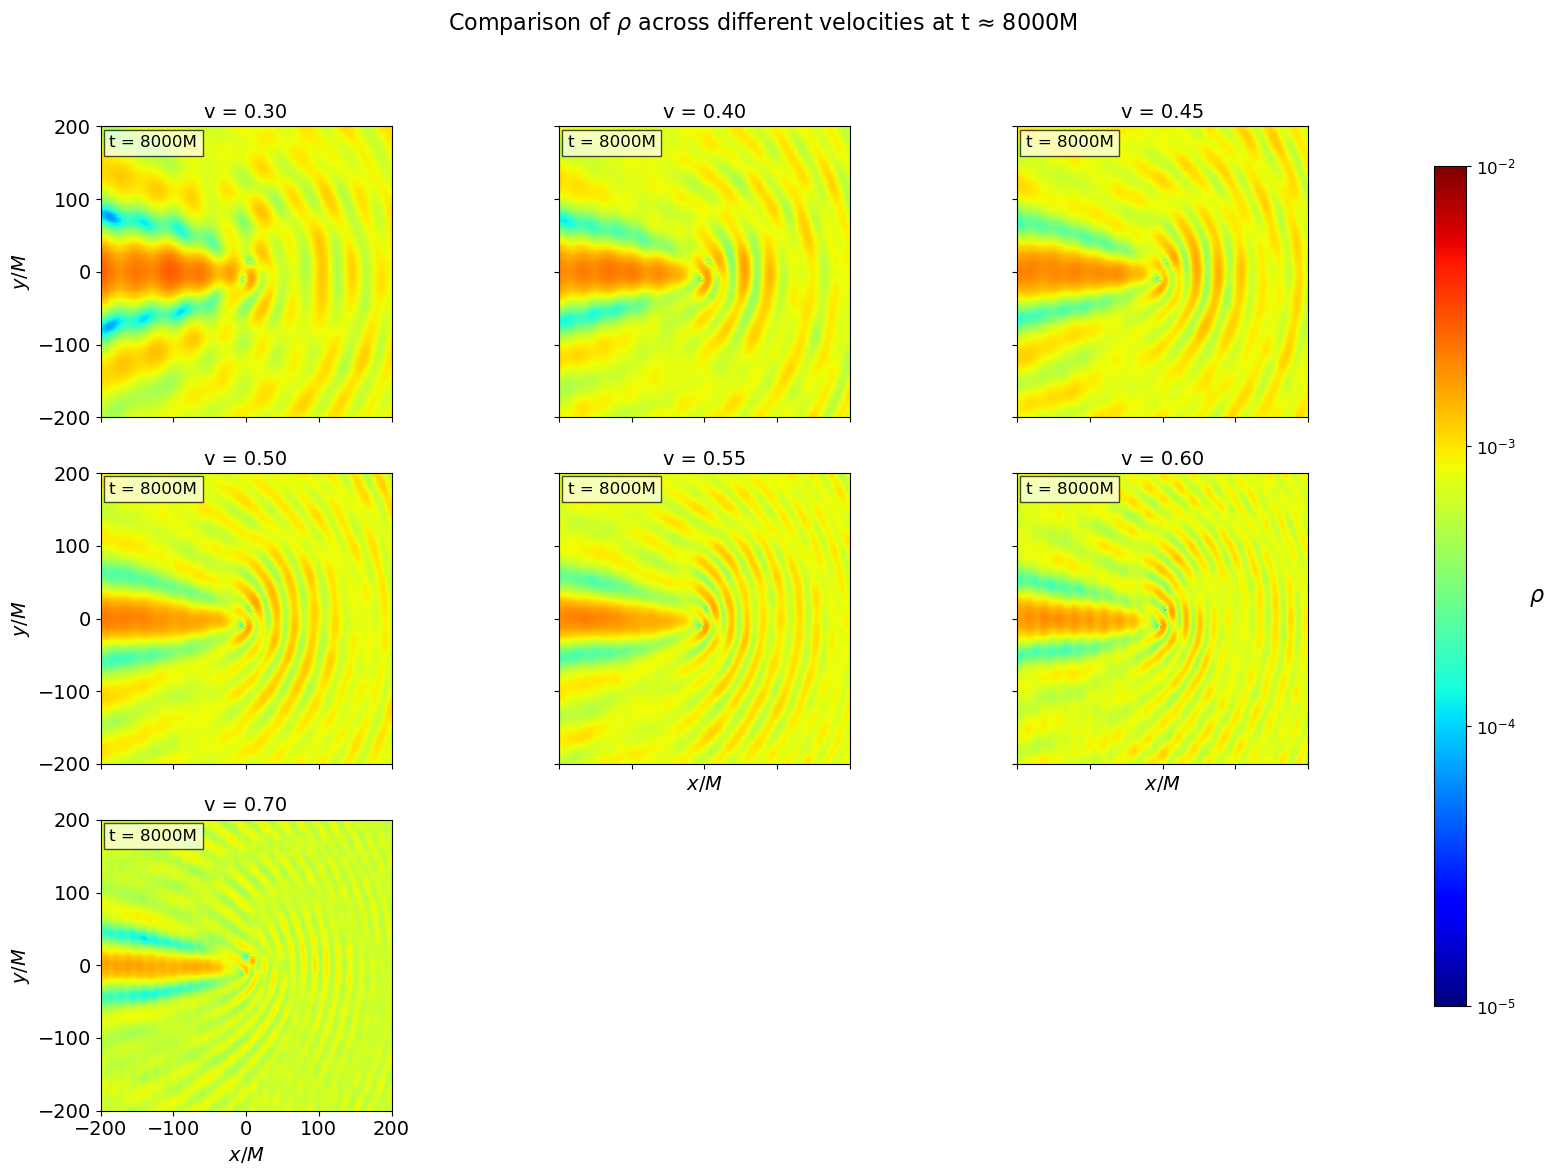

In [37]:
# Step 7: Create the final plots for all simulations
# Now that we've tested our approach, let's generate the full plots

# Load all velocity datasets
print("Loading all velocity comparison datasets...")
velocity_datasets_all = load_datasets_by_time(velocity_simnames, time_snapshot)

# Create the velocity comparison plot
if velocity_datasets_all:
    fig_velocity = create_multipanel_plot(
        velocity_datasets_all,
        f'Comparison of $\\rho$ across different velocities at t ≈ {time_snapshot}M',
        f'rho_energy_velocity_comparison_t{time_snapshot:.0f}.pdf',
        plot_cmap_min,
        plot_cmap_max
    )



Loading all resolution comparison datasets...

Processing simulation: 20250620_tune_damping_n256_1 (256)
Found 436 datasets, using first 2 to determine time step...
Using time step dt = 49.99M, estimated index: 159
Found dataset at time 8000.01M (diff: 0.01M)


  ✓ Loaded dataset with time 8000.01M
  ✓ Data shape: (800, 800), range: 0.00000000 to 0.00216941

Processing simulation: 20250621_tune_damping_n192 (192)
Found 420 datasets, using first 2 to determine time step...
Using time step dt = 49.98M, estimated index: 159
Found dataset at time 8000.02M (diff: 0.02M)
  ✓ Loaded dataset with time 8000.02M
  ✓ Data shape: (800, 800), range: 0.00000000 to 0.00222529

Processing simulation: 20250621_tune_damping_n128 (128)
Found 401 datasets, using first 2 to determine time step...
Using time step dt = 50.02M, estimated index: 159
Found dataset at time 8000.03M (diff: 0.03M)
  ✓ Loaded dataset with time 8000.03M
  ✓ Data shape: (800, 800), range: 0.00000000 to 0.00211652
Creating 3-panel plot: Comparison of $\rho$ across different resolutions at t ≈ 8000M
  Plotting panel 1/3: N = 128
  Plotting panel 2/3: N = 192
  Plotting panel 3/3: N = 256
  Adding colorbar...
  Adjusting layout...


/tmp/ipykernel_82271/1169290567.py:100: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.9, 0.96])  # Left, bottom, right, top


  Saving figure...
  ✓ Saved multi-panel plot to /pscratch/sd/x/xinshuo/plotGReX/rho_energy_resolution_comparison_t8000.pdf


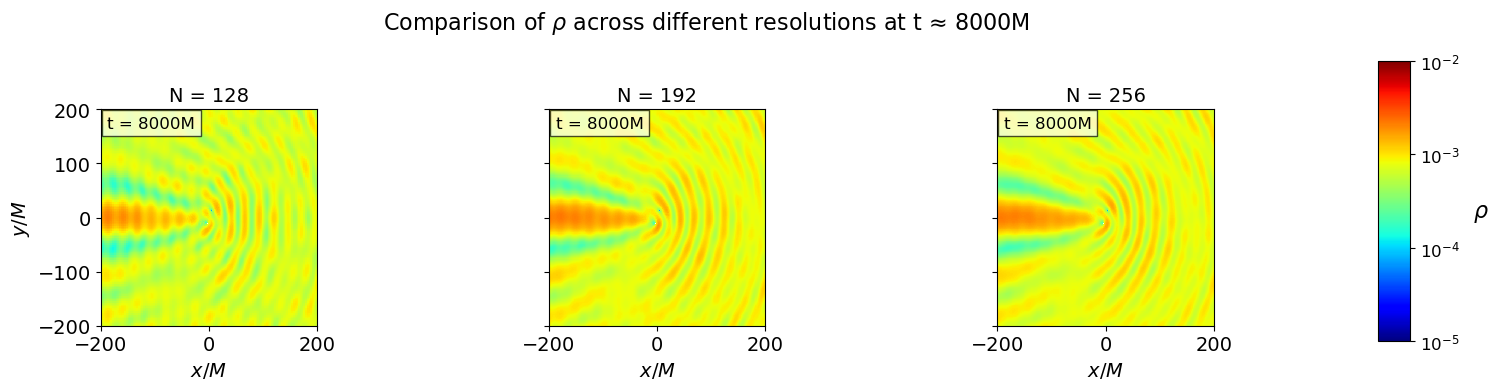

In [38]:

# Load all resolution (ncell) datasets
print("\nLoading all resolution comparison datasets...")
ncell_datasets = load_datasets_by_time(ncell_simnames, time_snapshot)

# Create the resolution comparison plot
if ncell_datasets:
    fig_ncell = create_multipanel_plot(
        ncell_datasets,
        f'Comparison of $\\rho$ across different resolutions at t ≈ {time_snapshot}M',
        f'rho_energy_resolution_comparison_t{time_snapshot:.0f}.pdf',
        plot_cmap_min,
        plot_cmap_max
    )
